# <b>PA005: High Value Customer Identification (Insiders)</b>

## <font color='blue'>0.0 Planejamento da solução (IOT) </font>

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização.

2. Conjunto de dados
    - Vendas de um e-commerce online, durante o período de um ano.

### Output - Saída

**1 - A indicação das pessoas que farão parte do programa de Insiders.**

Lista no formato:

| client_id | is_insiders|
| --------- | :--------: |
|   10323   |   yes / 1  |
|   32413   |   no / 0   |

</br>

**2 - Relatório com as respostas das perguntas de negócio.**

- Quem são as pessoas elegíveis para participar do programa de Insiders?

- Quantos clientes farão parte do grupo?

- Quais as principais características desses clientes?

- Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

- Qual a expectativa de faturamento desse grupo para os próximos meses?

- Quais as condições para uma pessoa ser elegível ao Insiders?

- Quais as condições para uma pessoa ser removida do Insiders?

- Qual a garantia que o programa Insiders é melhor que o restante da base?

- Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Task - Tarefas

1. **Quem são as pessoas elegíveis para participar do programa de Insiders?**

    - O que é ser elegível? O que são clientes de maior "valor"?
    
    - As respostas devem ser obtidas a partir de discussões com o time de negócios. Mas caso não conseguirmos discutir com eles, podemos elencar nossas próprias hipóteses:

        - Faturamento:
            - Alto Ticket Médio.
            - Alto LTV ( Lifetime Value ).
            - Baixa Recência ( intervalo de tempo desde a última compra ).
            - Alto Basket Size ( número de produtos na cesta ).
            - Baixa probabilidade de Churn.
            - Alta propensão de compra.
            
        - Custo:
            - Baixa taxa de devolução.

        - Experiência de compra
            - Média alta das avaliações.

</br>

2. **Quantos clientes farão parte do grupo?**

    - Número total de clientes.

    - % do grupo Insiders.

</br>

3. **Quais as principais características desses clientes?**

    - Escrever características do cliente:
        - Idade.
        - Localização.
        
    - Escrever características do consumo:
        - Atributos da clusterização.

</br>

4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders?**
    
    - Faturamento total do ano.
    
    - Faturamento do grupo Insiders.

</br>

5. **Qual a expectativa de faturamento desse grupo para os próximos meses?**

    - LTV do grupo Insiders.

    - Análise de Cohort.

</br>

6. **Quais as condições para uma pessoa ser elegível ao Insiders?**

    - Definir uma periodicidade para rodar o algoritmo de clusterização.
        - Atualiza os membros do cluster de Insiders.
        - Verifica se houve mudanças nas características dos membros dos grupo.

    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo Insiders.

</br>

7. **Quais as condições para uma pessoa ser removida do Insiders?**

    - Definir uma periocididade para rodar o algoritmo de clusterização.

    - A pessoa precisa ser dessimilar ou não-parecida com uma pessoa do grupo Insiders.

</br>

8. **Qual a garantia que o programa Insiders é melhor que o restante da base?**

    - Teste A/B.

    - Teste A/B Bayesiano.

    - Teste de Hipóteses.

</br>

9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**

    - Desconto.

    
    - Preferência de compra.
    
    - Frete.
    
    - Visita a empresa.

### Benchmark de soluções

1. **Desk Research**

    - Verificar como outras empresas estão resolvendo o problema em questão.
    
    - Separar 3 ou 4 soluções para discussão com os outros membros do squad para discustir a viabilidade dela ou se é possível aproveitar alguma parte.

### 0.0 Imports

In [32]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import HTML

### 0.1 Helper Functions

In [2]:
def jupyter_settings():

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24

    display( HTML('<style>.container { width:100% !important; } </style>') )

    # pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    # pd.set_option('display.expand_frame_repr', False)

    sns.set_theme()

jupyter_settings() 

### 0.2 Load dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='latin')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )


df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color="blue">1.0 Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols_name = df1.columns

df1.columns = map( lambda col: re.sub(r'([a-z])([A-Z])', r'\1_\2', col).lower(), cols_name )

df1.columns


Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.2 Data dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### 1.3 Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [9]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


Variáveis como `invoice_no` e `invoice_date` não estão com o tipo correto.

### 1.4 Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [11]:
# remove na
df1 = df1.dropna( subset=['description', 'customer_id'])

print('Removed data: {:.2f}'.format(1 - df1.shape[0]/ df_raw.shape[0]))

Removed data: 0.25


In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.6 Change dtypes

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [14]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [15]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

df1['customer_id'] = df1['customer_id'].astype( int )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.7 Descriptive Statistics

## <font color="blue">2.0 Feature Engineering </font>

In [17]:
df2 = df1.copy()

### Feature Creation

In [21]:
# data reference
df_ref = df2[['customer_id']].drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [22]:
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = ( df2[['customer_id', 'gross_revenue']]
                    .groupby('customer_id')
                    .sum()
                    .reset_index()
            )

df_ref = pd.merge(left=df_ref, right=df_monetary, how='left', on='customer_id')


# Recency
df_recency = ( df2[['customer_id', 'invoice_date']]
                    .groupby('customer_id')
                    .max()
                    .reset_index()
            )

df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

df_ref = pd.merge(left=df_ref, right=df_recency, how='left', on='customer_id')



# Frequency
df_frequency = ( df2[['customer_id', 'invoice_no']]
                    .drop_duplicates()
                    .groupby('customer_id')
                    .count()
                    .reset_index()
            ).rename(columns={'invoice_no': 'frequency'})

df_ref = pd.merge(left=df_ref, right=df_frequency, how='left', on='customer_id')

df_ref.head()


# Avg Ticket
df_avg_ticket = ( df2[['customer_id', 'gross_revenue']]
                   .groupby('customer_id')
                   .mean()
                   .reset_index()
            ).rename(columns={'gross_revenue': 'avg_ticket'})


df_ref = pd.merge(left=df_ref, right=df_avg_ticket, how='left', on='customer_id')

df_ref.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


## <font color="blue">3.0 Filtragem de Variáveis </font>

## <font color="blue">4.0 Exploratory Data Analysis </font>

## <font color="blue">5.0 Data Preparation </font>

## <font color="blue">6.0 Feature Selection </font>

## <font color="blue">7.0 Hyperparameter Fine-Tuning </font>

In [23]:
X = df_ref.drop(columns=['customer_id'])

In [24]:
X.head()

,gross_revenue,recency_days,frequency,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


### 7.1 Within-Cluster Sum of Square (WCSS)

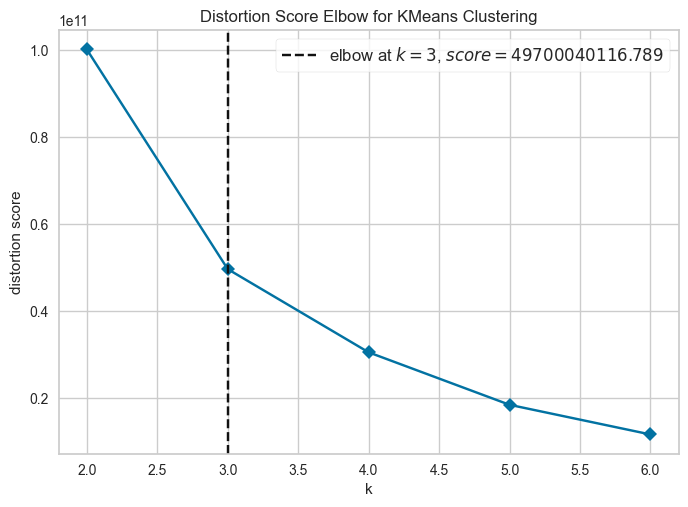

In [31]:
from yellowbrick.cluster import KElbowVisualizer

clusters = np.arange(2, 8)

kmeans_yellow = KElbowVisualizer(KMeans(), k=clusters, timings=False)
kmeans_yellow.fit(X)

kmeans_yellow.show();

### 7.2 Silhouette Score

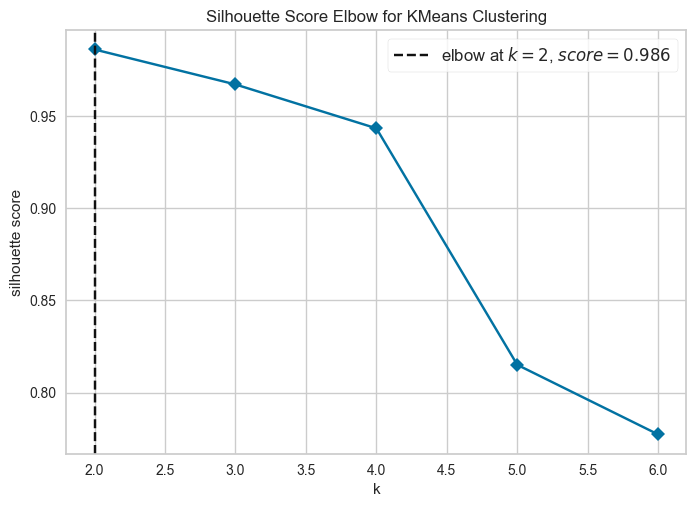

In [28]:
kmeans_yellow = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans_yellow.fit(X)

kmeans_yellow.show();

### 7.3 Silhouette Analysis

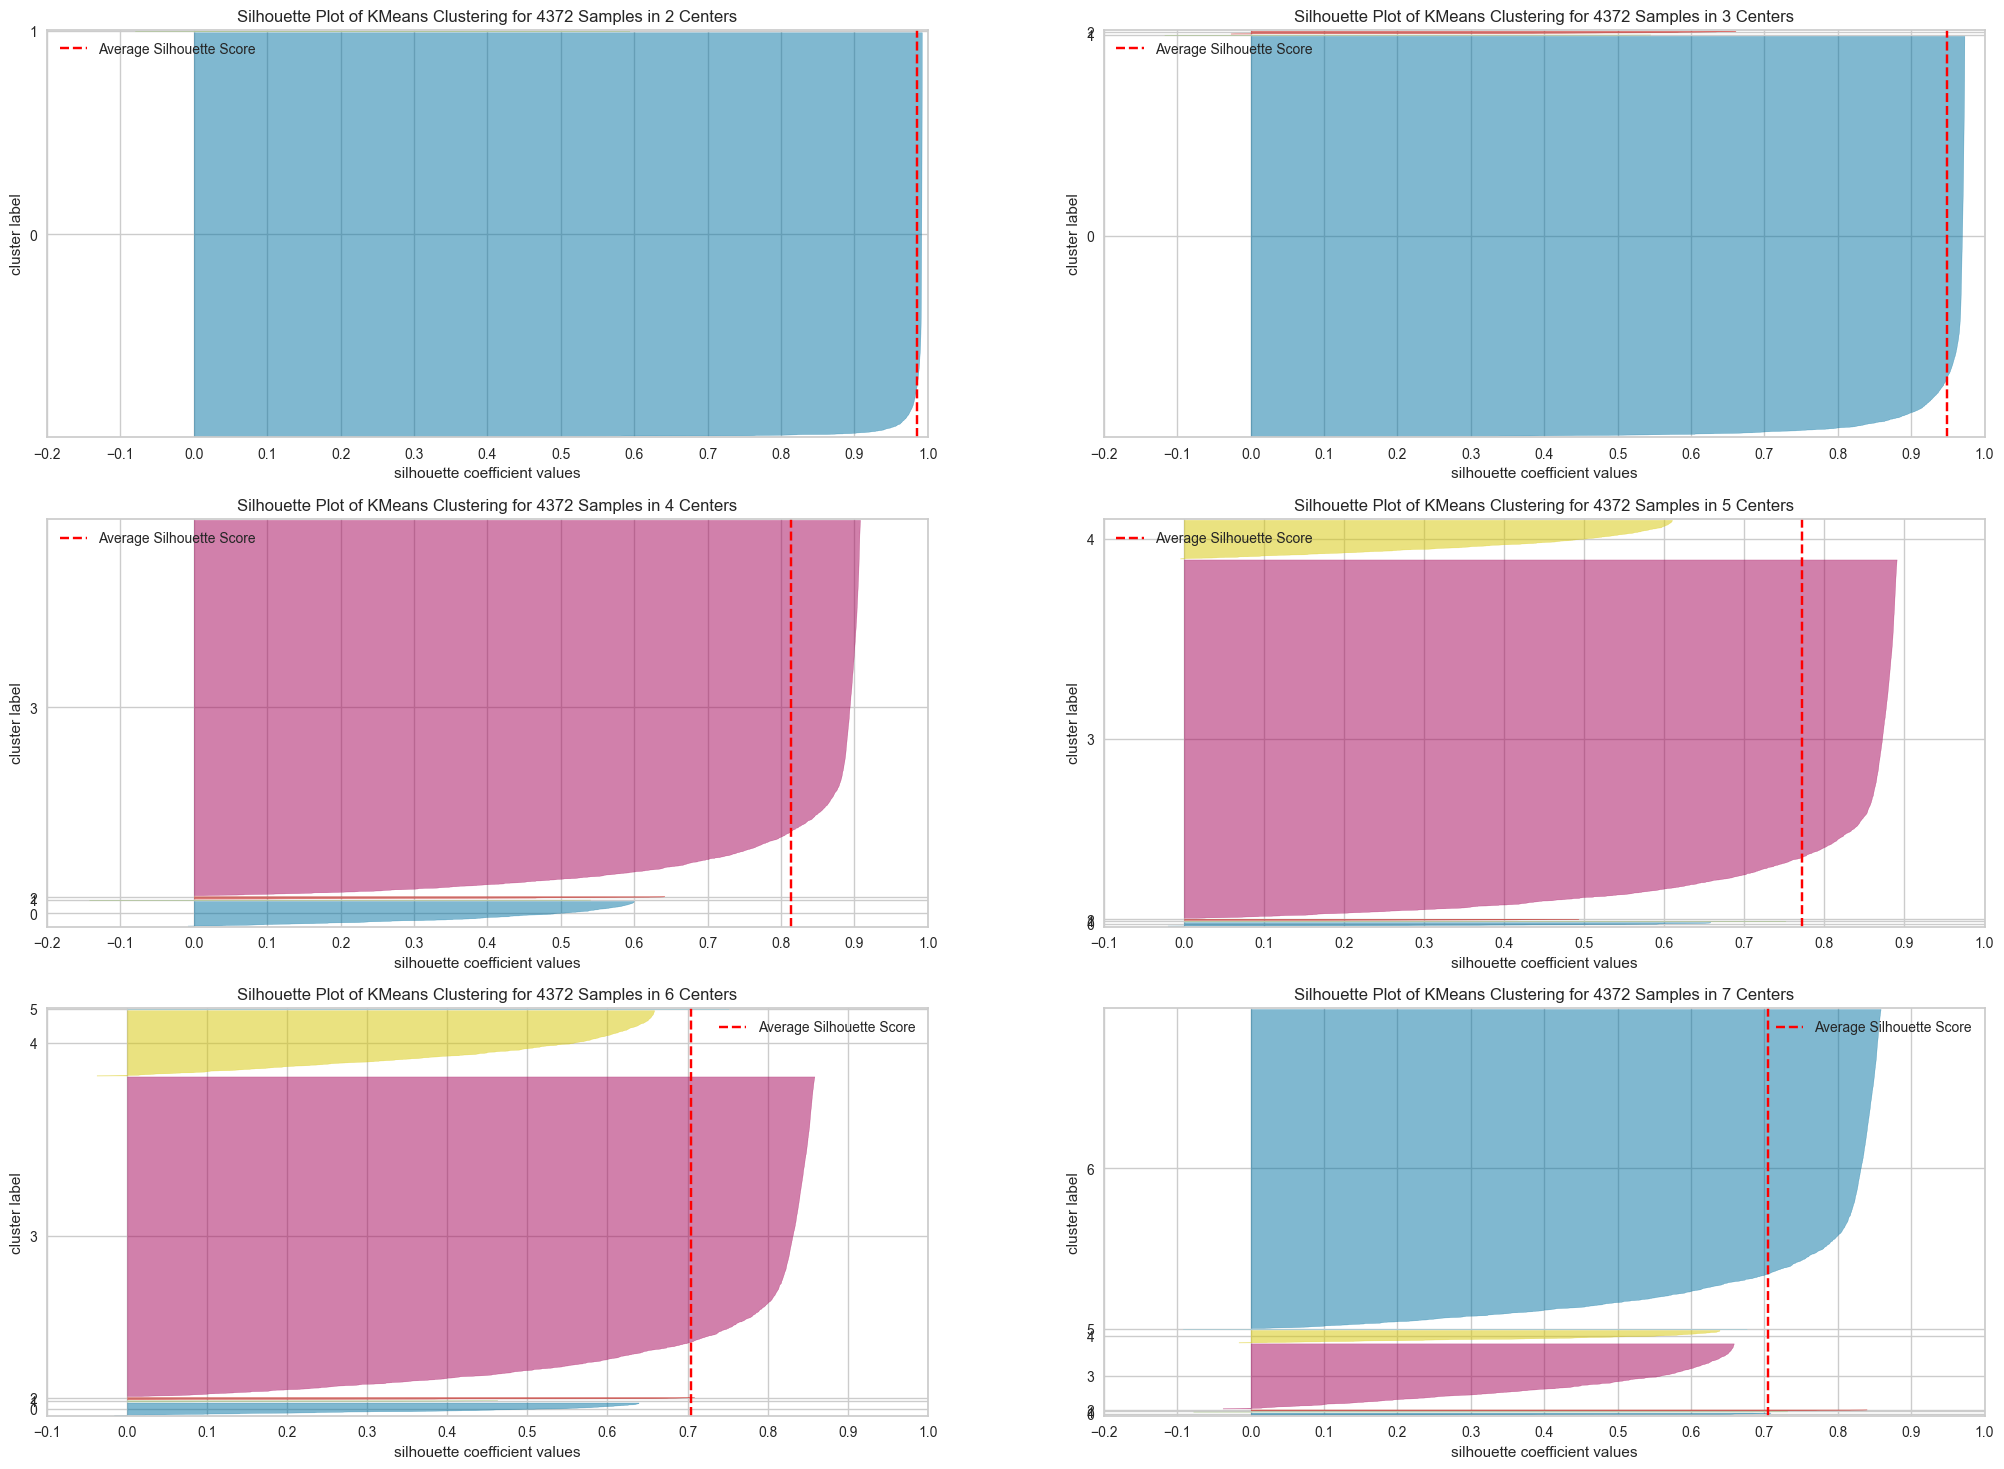

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 18))

for k, ax in zip(clusters, axes.ravel()):

    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)

    visualizer = SilhouetteVisualizer(estimator=km, colors='yellowbrick', ax=ax)
    visualizer.fit(X)
    
    visualizer.finalize();


## <font color="blue">8.0 Model Training </font>

### 8.1 K-Means

In [87]:
# model definition
k_best = 4
kmeans = KMeans(init='random', n_clusters=k_best, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X.values)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [88]:
# WCSS (Within-Cluster Sum of Square)
print('WCSS value\t: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
ss_value = silhouette_score(X, labels, metric='euclidean')
print('SS value\t: {}'.format(ss_value))

WCSS value	: 40056506734.60243
SS value	: 0.8139972028952444


## <font color="blue">9.0 Cluster Analysis </font>

In [89]:
df9 = df_ref.copy()

df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,0
1,13047,3079.10,31,18,15.709694,3
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,330,6,105.850000,3


### 9.1 Visualization Inspection

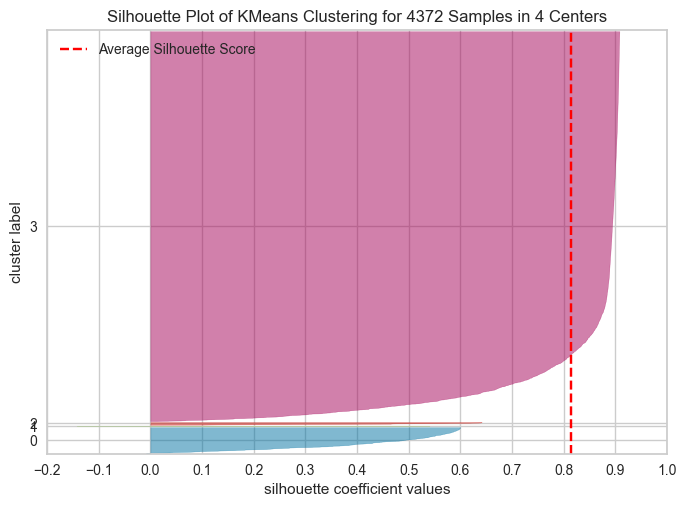

In [92]:
visualizer = SilhouetteVisualizer(estimator=kmeans, colors='yellowbrick')
visualizer.fit(X.values)
visualizer.finalize();

### 9.2 2d plot

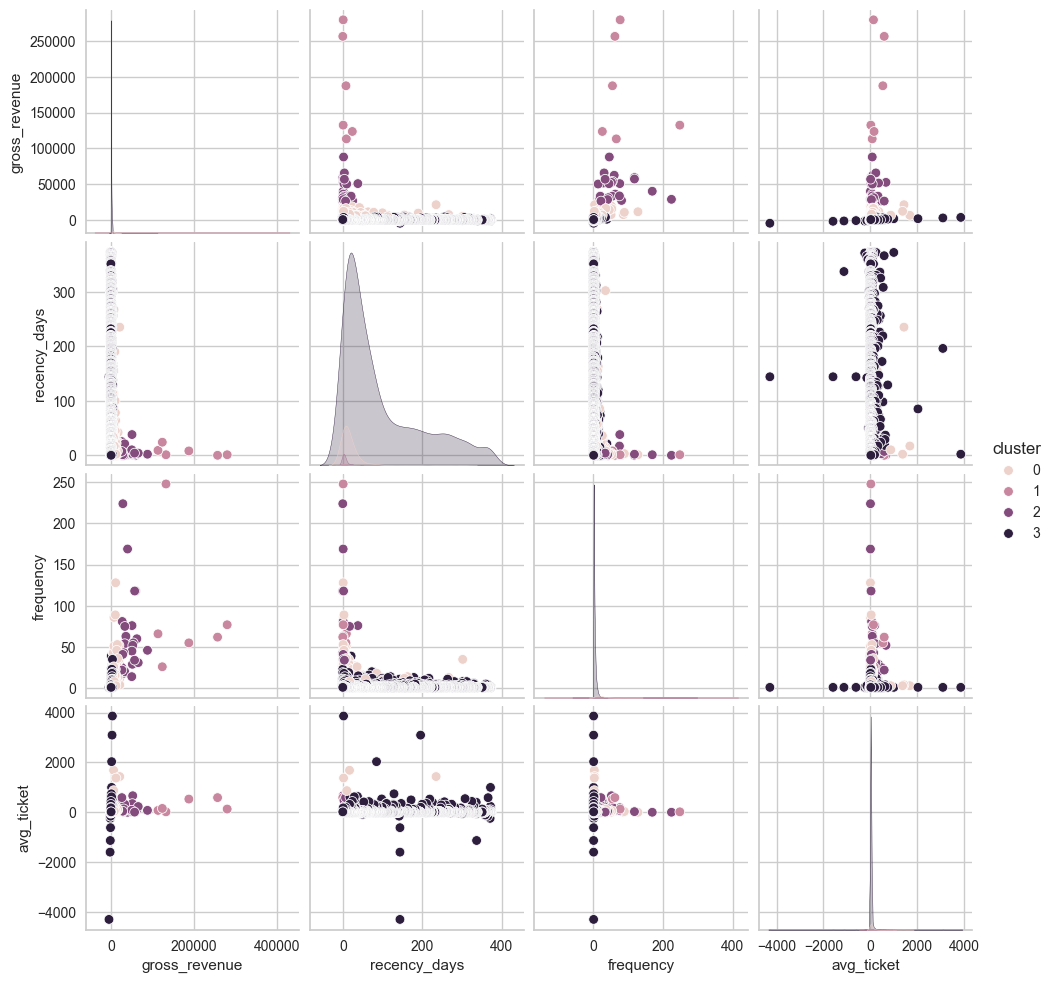

In [96]:
df_viz = df9.drop(columns=['customer_id'], axis=1)

sns.pairplot(df_viz, hue='cluster');

### 9.3 UMAP - t-SNE

**PCA** -> Matriz, Espaço de distância

**UMAP, t-SNE (2009)** -> Manifold - Topologia

In [98]:
import umap.umap_ as umap

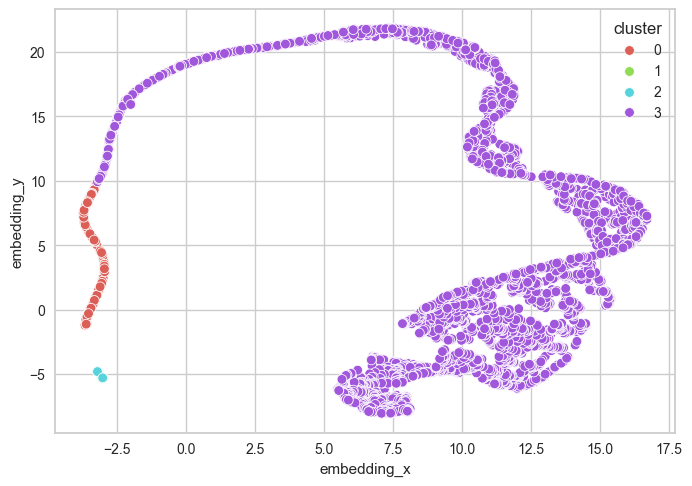

In [120]:
reducer = umap.UMAP(n_neighbors=20)

embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=k_best), data=df_viz);

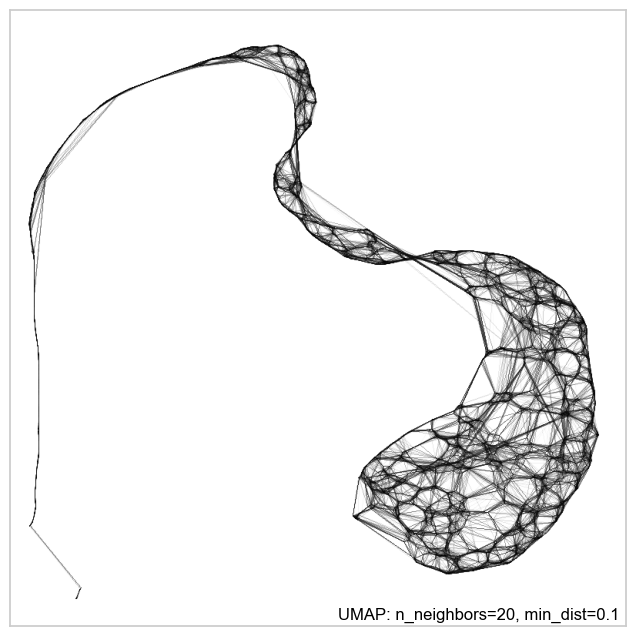

In [121]:
import umap.plot

embedding_plot = reducer.fit(X)

umap.plot.connectivity(embedding_plot);

### 9.4 Cluster Profile

In [51]:
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,0
1,13047,3079.10,31,18,15.709694,3
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,330,6,105.850000,3


In [122]:
# Number of customers
df_cluster = ( df9[['customer_id', 'cluster']]
                .groupby('cluster')
                .count()
                .reset_index()

        ).rename(columns={'customer_id': 'customers'})

df_cluster['perc_customer'] = 100 * df_cluster['customers'] / df_cluster['customers'].sum()

# Avg gross revenue
df_gross_revenue = ( df9[['gross_revenue', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_gross_revenue, how='left', on='cluster')


# Avg recency days
df_recency = ( df9[['recency_days', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_recency, how='left', on='cluster')


# Avg frequency
df_frequency = ( df9[['frequency', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_frequency, how='left', on='cluster')


df_ticket = ( df9[['avg_ticket', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_ticket, how='left', on='cluster')


df_cluster

,cluster,customers,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,267,6.107045,8089.028652,20.280899,19.528090,62.783157
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,4071,93.115279,946.696250,96.969295,3.641120,25.359654


**Cluster 01: (Candidato a Insider)**
- Número de customers: 6 (0.14% dos clientes)
- Recência média: 7 dias
- Compras em média: 89 compras
- Receita média: $182.182,00


**Cluster 02:**
- Número de customers: 31 (0.71% dos clientes)
- Recência média: 14 dias
- Compras em média: 53 compras
- Receita média: $40.543,52


**Cluster 03:**
- Número de customers: 4335 (99% dos clientes)
- Recência média: 92 dias
- Compras em média: 5 compras
- Receita média: $1.372,57

## <font color="blue">10.0 Deploy to Production </font>